In [8]:
# 표준 라이브러리
from typing import Literal
from typing_extensions import TypedDict, List
import os 

# 서드파티 라이브러리
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, START, END
from pyzerox import zerox

# LangChain 관련 라이브러리
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import (
    PyPDFLoader,
    UnstructuredMarkdownLoader,
    TextLoader,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langchain import hub

load_dotenv()


True

In [2]:
MODEL_NAME = "gemma2-9b-it"

llm = ChatGroq(model_name=MODEL_NAME)


# 이미 생성된 크로마 db 가져오기
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sroberta-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)


vector_store = Chroma(
    embedding_function=embeddings_model,
    collection_name = "income_tax_collection",
    persist_directory = "./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs = {"k":3})

C:\Users\user\AppData\Local\Temp\ipykernel_10664\3184129235.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(
c:\USERS\USER\DESKTOP\FINBRAINAGENT\VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class AgentState(TypedDict):
    query: str
    context: List
    answer: str


prompt = hub.pull("rlm/rag-prompt")
generate_prompt = hub.pull("rlm/rag-prompt")
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")


def retrieve(state: AgentState):
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context" : docs}

def generate(state: AgentState):

    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | llm | StrOutputParser()
    

    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response}


def check_doc_relevance(state : AgentState) -> Literal['relevant', 'irrelevant']:
    query = state["query"]
    context = state["context"]
    print(f"context == {context}")
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"question" : query, "documents" : context})
    print(f"response == {response}")
    if response["Score"] ==1:
        return "relevant"
    return "irrelevant"

In [7]:

rewrite_prompt = PromptTemplate.from_template("""사용자 질문을 보고, 웹 검색에 용이하게 사용자 질문을 수정해라 
                                              질문: {query}""")
def rewrite(state: AgentState):
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    

    response = rewrite_chain.invoke({"query" : query})
    print(f"rewrite_response =={response}")
    return {"query" : response}

In [12]:
tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState):
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    print(f"web_search_results == {results}")
    return {"context": results}


In [13]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("web_search", web_search)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges(
    "retrieve",
    check_doc_relevance,
    {
        "relevant": "generate",
        "irrelevant": "rewrite"
    },
)

graph_builder.add_edge("rewrite", "web_search")
graph_builder.add_edge("web_search", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()


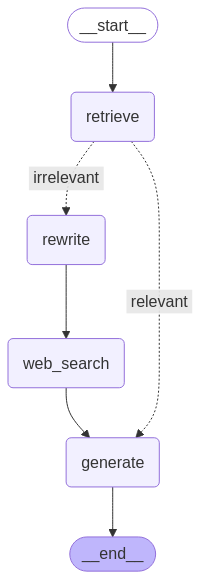

In [14]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph(xray=True).draw_mermaid_png()
    )
)


In [15]:
initial_state = {"query": "강남역 맛집 추천해라"}

graph.invoke(initial_state)


context == [Document(id='a58b5c03-3e00-4a5d-b672-362416d15e60', metadata={'source': './documents/income_tax.txt'}, page_content='담당세무서로서 담당공무원에게 지명이음으로는 보호를 위하는 바에 따라 담의 다음을 말하기는 것에 대한 해상금의 숙소는 본 해당하는 숙소는 달의 다음과 함께 말할 것이다. <개정 2020. 12. 29, 2021. 3. 16.>\n법제처 151\n국가법전정보센터'), Document(id='533fb97c-cf2d-4873-b2ee-922ae4fbb6e8', metadata={'source': './documents/income_tax.txt'}, page_content='범죄처 122 국가법정정보센터\n한다. <개정 2009. 12. 31, 2010. 12. 27.>\n⑥ 사업자(법인은 포함한다. 이하 이 약에서 같다)가 음식, 숙박용역이나 서비스용역을 공급하고 그 대가를 받을 때 지정제한법에 따른 봉사료를 포함하여 하여야 소득세가 그 사업자에게 대한 소득세를 원천징수하여야 한다. <개정 2009. 12. 31, 2010. 12. 27.>\n⑦ 제정부칙 제향까지의 규정에 이어야 할 자를 “원천징수의무자”라 한다. <개정 2010. 12. 27.>\n⑧ 원천징수의무자의 범위 등 밖에 필요한 사항을 대통령령으로 정한다. <신설 2013. 1. 1.> \n[제목개정 2009. 12. 31]\n제127조(원천징수의무) \n국내에서 거주자나 비거주자에게 다음 각 호의 어느 하나에 해당하는 소득을 지급하는 자(제3호 또는 제4호의 소득을 지급하는 자의 경우에는 사업자)는 대통령령으로 정하는 바에 의하여 그 사업자가 그 소득세를 원천징수하여야 한다. <개정 2009. 12. 31, 2010. 12. 27, 2015. 12. 15, 2020. 12. 29.>\n1. 이자소득\n2. 배당소득\n3. 대여금융소득을 정의하는 사업소득(이하 “원천징수대상 

{'query': '## 사용자 질문 수정: 강남역 맛집 추천 \n\n다음과 같은 방법으로 웹 검색에 용이하게 수정할 수 있습니다. \n\n1. **요리 종류를 명시:** \n    * 강남역 **한식 맛집** 추천해라\n    * 강남역 **피자 맛집** 추천해라\n    * 강남역 **고기 맛집** 추천해라\n\n2. **가격대를 명시:**\n    * 강남역 **저렴한 맛집** 추천해라\n    * 강남역 **고급 맛집** 추천해라\n    * 강남역 **1인 기준 1만원 이내 맛집** 추천해라\n\n3. **특정 분위기나 테마를 명시:**\n    * 강남역 **분위기 좋은 데이트 맛집** 추천해라\n    * 강남역 **가족끼리 갈 수 있는 맛집** 추천해라\n    * 강남역 **친구들과 모여서 먹기 좋은 맛집** 추천해라\n\n4. **구체적인 메뉴를 언급:**\n    * 강남역 **닭갈비 맛집** 추천해라\n    * 강남역 **파스타 맛집** 추천해라\n    * 강남역 **갈비찜 맛집** 추천해라\n\n5. **추가 정보를 포함:**\n    * 강남역 **맛집 숨은 명소** 추천해라\n    * 강남역 **보이지 않는 맛집** 추천해라\n    * 강남역 **지하철 1호선 강남역 근처 맛집** 추천해라\n\n\n\n위와 같은 방법으로 질문을 수정하면 좀 더 정확하고 유용한 검색 결과를 얻을 수 있습니다.\n',
 'context': "HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')",
 'answer': "I don't know. I am not able to access external websites or APIs to retrieve information.  My knowledge is based on the text data I was trained on. \n"}

In [16]:
no_rewrite_graph_builder = StateGraph(AgentState)

no_rewrite_graph_builder.add_node("retrieve", retrieve)
no_rewrite_graph_builder.add_node("generate", generate)

no_rewrite_graph_builder.add_node("web_search", web_search)

no_rewrite_graph_builder.add_edge(START, "retrieve")
no_rewrite_graph_builder.add_conditional_edges(
    "retrieve",
    check_doc_relevance,
    {
        "relevant": "generate",
        "irrelevant": "web_search"
    },
)

no_rewrite_graph_builder.add_edge("web_search", "generate")
no_rewrite_graph_builder.add_edge("generate", END)

no_rewrite_graph = no_rewrite_graph_builder.compile()


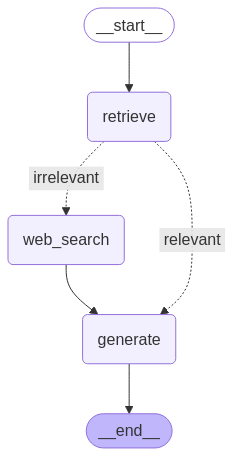

In [17]:
display(
    Image(
        no_rewrite_graph.get_graph(xray=True).draw_mermaid_png()
    )
)


In [18]:
initial_state = {"query": "강남역 맛집 추천해라"}

no_rewrite_graph.invoke(initial_state)


context == [Document(id='a58b5c03-3e00-4a5d-b672-362416d15e60', metadata={'source': './documents/income_tax.txt'}, page_content='담당세무서로서 담당공무원에게 지명이음으로는 보호를 위하는 바에 따라 담의 다음을 말하기는 것에 대한 해상금의 숙소는 본 해당하는 숙소는 달의 다음과 함께 말할 것이다. <개정 2020. 12. 29, 2021. 3. 16.>\n법제처 151\n국가법전정보센터'), Document(id='533fb97c-cf2d-4873-b2ee-922ae4fbb6e8', metadata={'source': './documents/income_tax.txt'}, page_content='범죄처 122 국가법정정보센터\n한다. <개정 2009. 12. 31, 2010. 12. 27.>\n⑥ 사업자(법인은 포함한다. 이하 이 약에서 같다)가 음식, 숙박용역이나 서비스용역을 공급하고 그 대가를 받을 때 지정제한법에 따른 봉사료를 포함하여 하여야 소득세가 그 사업자에게 대한 소득세를 원천징수하여야 한다. <개정 2009. 12. 31, 2010. 12. 27.>\n⑦ 제정부칙 제향까지의 규정에 이어야 할 자를 “원천징수의무자”라 한다. <개정 2010. 12. 27.>\n⑧ 원천징수의무자의 범위 등 밖에 필요한 사항을 대통령령으로 정한다. <신설 2013. 1. 1.> \n[제목개정 2009. 12. 31]\n제127조(원천징수의무) \n국내에서 거주자나 비거주자에게 다음 각 호의 어느 하나에 해당하는 소득을 지급하는 자(제3호 또는 제4호의 소득을 지급하는 자의 경우에는 사업자)는 대통령령으로 정하는 바에 의하여 그 사업자가 그 소득세를 원천징수하여야 한다. <개정 2009. 12. 31, 2010. 12. 27, 2015. 12. 15, 2020. 12. 29.>\n1. 이자소득\n2. 배당소득\n3. 대여금융소득을 정의하는 사업소득(이하 “원천징수대상 

{'query': '강남역 맛집 추천해라',
 'context': [{'url': 'https://www.siksinhot.com/taste?upHpAreaId=9&hpAreaId=33&isBestOrd=N',
   'content': '추천 맛집(271)식신과 매장 방문 고객님들이 함께 엄선한 인기 맛집입니다. · best. 4.2. 강남교자. 강남역 · best. 4.4. 도치피자. 주차 · best 착한식당. 4.1. 시골야채된장.'},
  {'url': 'https://m.blog.naver.com/twin_couple/222717441660',
   'content': '1. 강남역 제철한식 맛집 : 들름집 · 2. 강남역 맛집 : 기와집양대창 · 3. 강남역 룸있는 #식당 : 우탭 · 4. #강남역맛집 매운갈비찜 : 푸에르코 강남 · 5.'},
  {'url': 'https://m.blog.naver.com/twin_couple/222831691893',
   'content': '강남역 맛집 내돈내산 14군데 모음 (3탄) : 네이버 블로그 강남역 맛집 내돈내산 14군데 모음 (3탄) #직장인 #점심 먹으러 자주가는 #강남역 #맛집 #정리! #식당 선정 필요할 때, #메뉴 고민될 때 나를 위해 해보는 간단한 #강남역 #맛집 #내돈내산 #기록 #모음~ 벌써 3탄이네;;;ㅋㅋ 내 기준 맛집은 #맛집 으로, 그 정도는 아니면 그냥 #식당 으로 표기합니다. 1. 강남역 맛집 : 신도세기 아 여기 낙지가 진짜 실하다ㅎㅎㅎㅎ 근데 점심메뉴용이 있고, 따로 메인요리로 시키는 게 있는데, 같이 가신 분이 메인요리로 시켜주셔서 더 실하고 양도 많았던 거 같기도... 강남역 맛집 무교동낙지 4. 강남역 맛집 : 소호정 강남역 맛집 소호정 강남역 맛집 낙원타코 9. 강남역 맛집 : 해우담 강남역 맛집 푸에르코 ▼ 강남역 내돈내산 직장인 점심 맛집 모음 1탄 ▼ 강남역 내돈내산 직장인 점심 맛집 모음 2탄'}],
 'answer': '강남역 맛집으로 강남교자, 도치피자